In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Lambda, Dense, Input
from keras.callbacks import ModelCheckpoint 

from keras import optimizers
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files 
from tqdm import tqdm

Using TensorFlow backend.


# Load and examine the dataset

In [2]:
def load_dataset(path):
    # the sklearn.datasets.load_files function takes a dataset directory as an input
    # for each folder within the directory, the folder name should be a category
    # within each folder will be samples corresponding to their category
    # load_files returns a bunch object which is a dictionary with 'DESC', 
    # 'data', 'filenames', 'target' as keys
    data = load_files(path)
    # an array of file paths or directories
    data_files = np.array(data['filenames']) 
    data_labels = np_utils.to_categorical(np.array(data['target']), 10)
    return data_files, data_labels

In [3]:
train_data_dir = "imgs/train"
faked_data_dir = "faked/"
data_directory = faked_data_dir

In [4]:
train_files, train_labels = load_dataset(data_directory)
print("There are {} total training images.".format(len(train_files)))

There are 20 total training images.


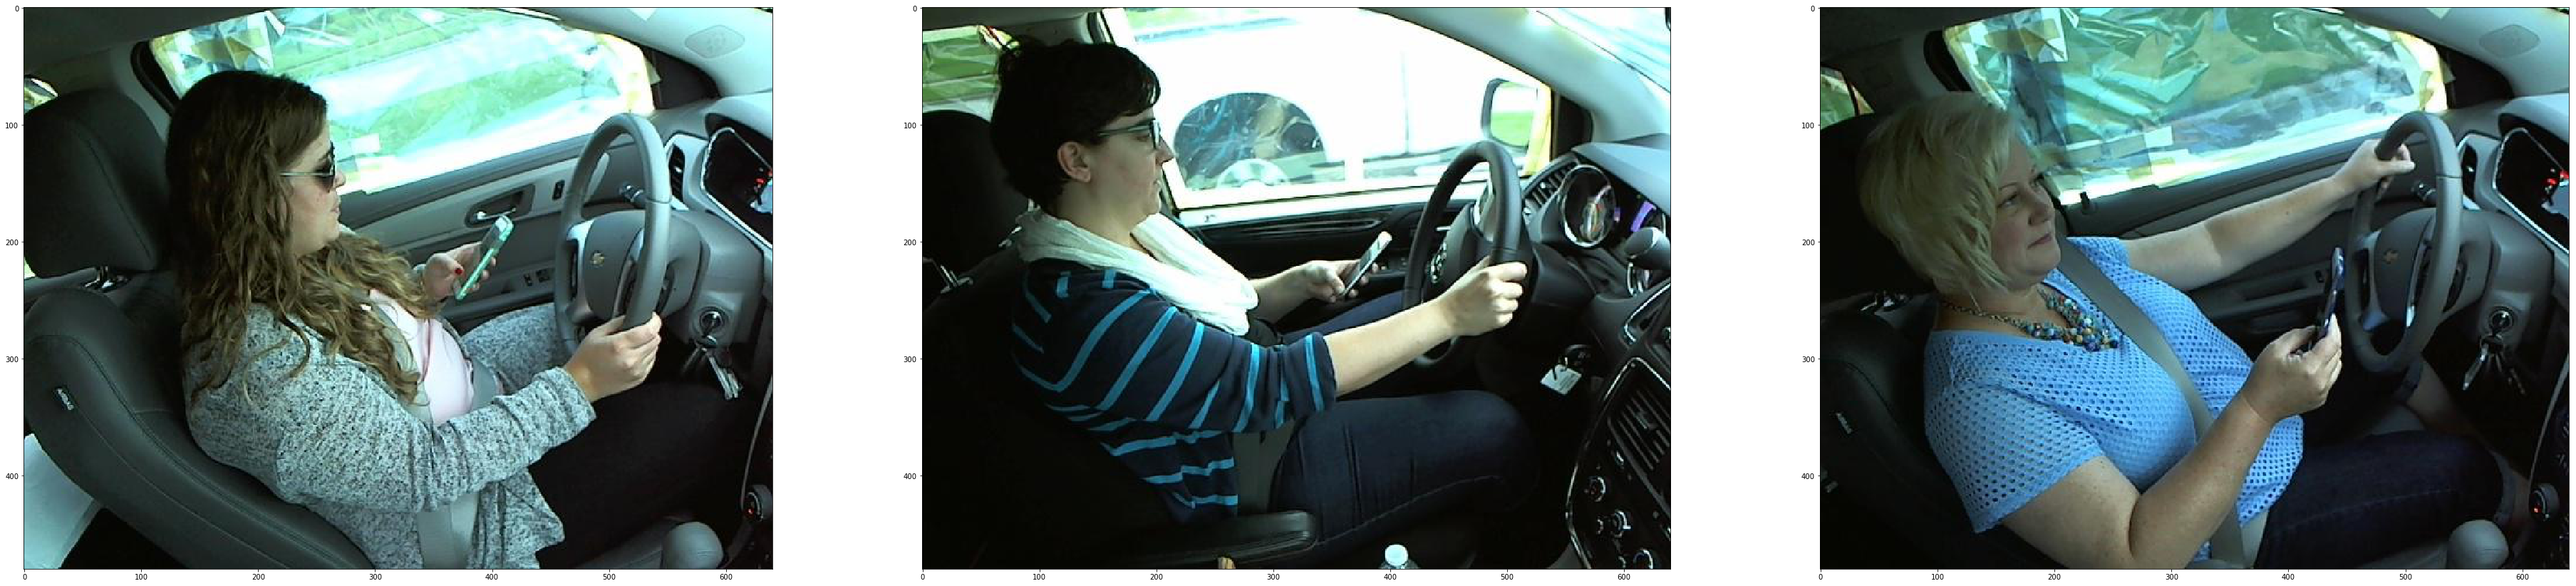

In [5]:
# Random visualize some image data
samples = np.random.choice(train_files, 3)
imgs = []
for sample in samples: 
    img = mpimg.imread(sample)
    imgs.append(img)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(64, 48))
ax1.imshow(imgs[0])
ax2.imshow(imgs[1])
ax3.imshow(imgs[2])
plt.show()

# Model building

I want to use transfer learning to boost the performance, and to obtain a proper weighted top layer, I have to get the bottleneck features from my own dataset and then train the top layer with bottleneck features as inputs, then after that, finetune the model.

### About preprocess_input

Getting the 4D tensor ready for VGG19, and for any other pre-trained model in Keras, requires some additional processing. See below link for more detailed operations: [preprocess_input](https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py)

In [6]:
# Hyperparameters setting
batch_size = 1
epochs = 20
target_size=(299, 299)

In [7]:
InceptionV3_model = InceptionV3(include_top=False, weights='imagenet')

In [8]:
# I had to conduct data split with Sklearn's `train_test_split ` for later use in the bottleneck training process
# as ImageDataGenerator do not return data labels after the data augumentation
# bacause for most of the time, the training is done with `fit_generator()`
X_train, X_valid, y_train, y_valid = train_test_split(train_files, train_labels, test_size=0.2)

In [9]:
y_train

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]], dtype=float32)

In [10]:
# Helper functions to process the training and validation data
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(path) for path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [11]:
X_train_data = paths_to_tensor(X_train)
X_valid_data = paths_to_tensor(X_valid)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 138.01it/s]


In [12]:
X_train_data = preprocess_input(X_train_data)
X_valid_data = preprocess_input(X_valid_data) 

In [13]:
bottleneck_features_training = InceptionV3_model.predict(X_train_data)
bottleneck_features_validation = InceptionV3_model.predict(X_valid_data)

np.savez('bottleneck_features_train.npz', 
         training=bottleneck_features_training, 
         validation=bottleneck_features_validation)

In [15]:
bottleneck_features = np.load('bottleneck_features_train.npz')
training_data = bottleneck_features['training']
validation_data = bottleneck_features['validation']

In [16]:
# The top layers are built making reference to the original InceptionV3 model
# However further modifications maybe needed
model = Sequential()
# The input shape from bottleneck_feature is (data_size, 8, 8, 2048)
model.add(GlobalAveragePooling2D(input_shape=training_data.shape[1:]))
model.add(Dense(10, name='top'))
# I run into a Keras and Tensorflow compatibility issue and using blow line as a bypass solution
model.add(Lambda(lambda x: K.tf.nn.softmax(x)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
top (Dense)                  (None, 10)                20490     
_________________________________________________________________
lambda_1 (Lambda)            (None, 10)                0         
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile the mode, with optimizer as `rmsprop`
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Set checkpointer for training callbacks
checkpointer = ModelCheckpoint(filepath='saved_models/bottleneck_weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

history = model.fit(training_data, y_train, 
                    validation_data=(validation_data, y_valid), 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[checkpointer], 
                    verbose=1)

model.evaluate(validation_data, y_valid)

Train on 16 samples, validate on 4 samples
Epoch 1/20
16/16 [==============================] - ETA: 13s - loss: 1.8283 - acc: 0.0000e+ - 1s 62ms/step - loss: 3.8436 - acc: 0.0000e+00 - val_loss: 4.9338 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 4.93381, saving model to saved_models/bottleneck_weights.best.hdf5
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 2.6578 - acc: 0.0000e+0 - 0s 3ms/step - loss: 2.0952 - acc: 0.0625 - val_loss: 5.5057 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve from 4.93381
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 0.9375 - acc: 1.000 - 0s 3ms/step - loss: 1.4176 - acc: 0.6250 - val_loss: 5.7637 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve from 4.93381
Epoch 4/20
16/16 [==============================] - ETA: 0s - loss: 0.5546 - acc: 1.000 - 0s 3ms/step - loss: 1.0408 - acc: 0.6875 - val_loss: 6.0833 - val_acc: 0.0000e+00

Epoch 00004: val_loss did not improve fr

[10.10771369934082, 0.25]

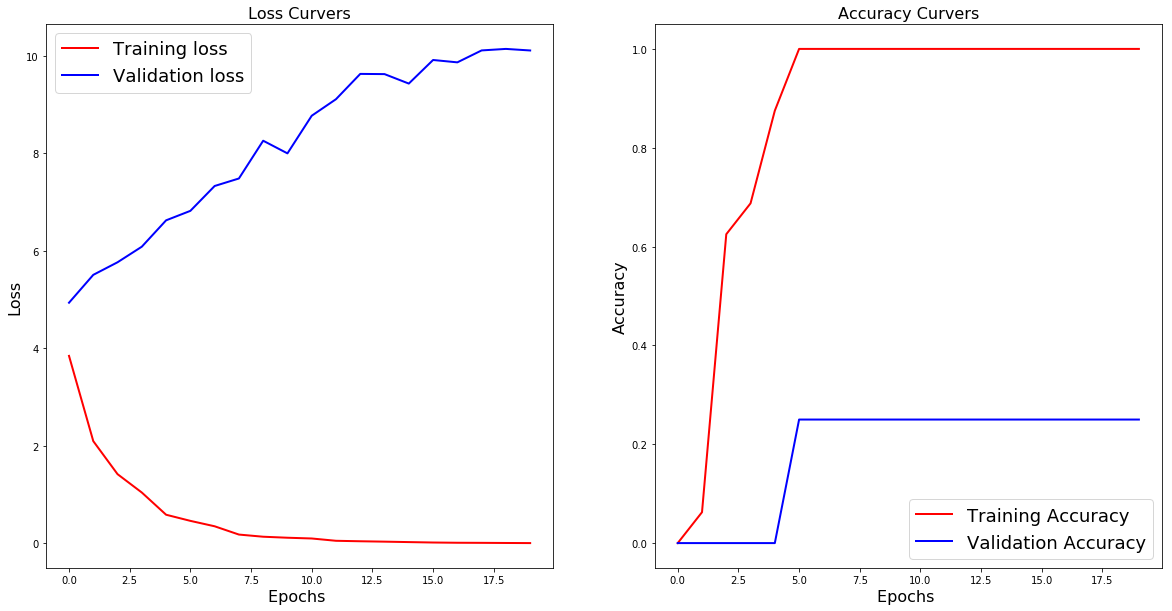

In [31]:
# Visualizing the losses and accuracies

# Loss Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(history.history['loss'], 'r', linewidth=2.0)
ax1.plot(history.history['val_loss'], 'b', linewidth=2.0)
ax1.legend(['Training loss', 'Validation loss'], fontsize=18)
ax1.set_xlabel('Epochs ', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
ax1.set_title('Loss Curvers', fontsize=16)

# Accuracy Curves
ax2.plot(history.history['acc'], 'r', linewidth=2.0)
ax2.plot(history.history['val_acc'], 'b', linewidth=2.0)
ax2.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
ax2.set_xlabel('Epochs ', fontsize=16)
ax2.set_ylabel('Accuracy', fontsize=16)
ax2.set_title('Accuracy Curvers', fontsize=16);

In [34]:
# Examine the training result manually
model.load_weights('saved_models/bottleneck_weights.best.hdf5')
# get index of predictions each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in validation_data]

# report test accuracy
validation_accuracy = 100 * np.sum(np.array(predictions)==np.argmax(y_valid, axis=1))/len(predictions)

print("Test accuracy: {:.4f}%".format(validation_accuracy))

Test accuracy: 0.0000%


# Finetuning the model 

In [56]:
# Better provide the input shape to made the summary more readible
input_tensor = Input(shape=(299, 299, 3))

base_model = InceptionV3(weights='imagenet', 
                         include_top=False, 
                         input_tensor=input_tensor)

top_model = Sequential()
top_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(10, name='top'))
top_model.add(Lambda(lambda x: K.tf.nn.softmax(x)))

# Load the pretrained weights to current top_model
top_model.load_weights('saved_models/bottleneck_weights.best.hdf5')
print("Pre-trained weights are loaded.")

tuning = Model(inputs=base_model.input, outputs=top_model(base_model.output))

for layer in tuning.layers[:250]:
    layer.trainable = False

tuning.summary()

Pre-trained weights are loaded.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_471 (Conv2D)             (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_471 (BatchN (None, 149, 149, 32) 96          conv2d_471[0][0]                 
__________________________________________________________________________________________________
activation_471 (Activation)     (None, 149, 149, 32) 0           batch_normalization_471[0][0]    
_____________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_490 (BatchN (None, 35, 35, 64)   192         conv2d_490[0][0]                 
__________________________________________________________________________________________________
batch_normalization_492 (BatchN (None, 35, 35, 64)   192         conv2d_492[0][0]                 
__________________________________________________________________________________________________
batch_normalization_495 (BatchN (None, 35, 35, 96)   288         conv2d_495[0][0]                 
__________________________________________________________________________________________________
batch_normalization_496 (BatchN (None, 35, 35, 64)   192         conv2d_496[0][0]                 
__________________________________________________________________________________________________
activation_490 (Activation)     (None, 35, 35, 64)   0           batch_normalization_490[0][0]    
__________

__________________________________________________________________________________________________
batch_normalization_511 (BatchN (None, 17, 17, 192)  576         conv2d_511[0][0]                 
__________________________________________________________________________________________________
batch_normalization_514 (BatchN (None, 17, 17, 192)  576         conv2d_514[0][0]                 
__________________________________________________________________________________________________
batch_normalization_519 (BatchN (None, 17, 17, 192)  576         conv2d_519[0][0]                 
__________________________________________________________________________________________________
batch_normalization_520 (BatchN (None, 17, 17, 192)  576         conv2d_520[0][0]                 
__________________________________________________________________________________________________
activation_511 (Activation)     (None, 17, 17, 192)  0           batch_normalization_511[0][0]    
__________

batch_normalization_544 (BatchN (None, 17, 17, 192)  576         conv2d_544[0][0]                 
__________________________________________________________________________________________________
activation_544 (Activation)     (None, 17, 17, 192)  0           batch_normalization_544[0][0]    
__________________________________________________________________________________________________
conv2d_541 (Conv2D)             (None, 17, 17, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_545 (Conv2D)             (None, 17, 17, 192)  258048      activation_544[0][0]             
__________________________________________________________________________________________________
batch_normalization_541 (BatchN (None, 17, 17, 192)  576         conv2d_541[0][0]                 
__________________________________________________________________________________________________
batch_norm

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_12[0][0]             
                                                                 activation_564[0][0]             
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 10)           20490       mixed10[0][0]                    
Total params: 21,823,274
Trainable params: 21,788,842
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [44]:
# As the dataset is huge, I wanted to do real time data augumentation with keras
# `validation_split` is only support in Keras 2.2.0 
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.2, 
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   preprocessing_function=preprocess_input, 
                                   validation_split=0.2)

valid_datagen = ImageDataGenerator(rescale=1./255, 
                                   preprocesing_function=preprocess_input)

In [45]:
# `subset` is only needed if `validation_split` is set
train_generator = train_datagen.flow_from_directory(data_directory, 
                                                    target_size=(299, 299), 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size, 
                                                    subset="training",
                                                    shuffle=True)

Found 20 images belonging to 10 classes.


In [46]:
validation_generator = valid_datagen.flow_from_directory(data_directory, 
                                                    target_size=(299, 299), 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size, 
                                                    subset="validation",
                                                    shuffle=False)

Found 0 images belonging to 10 classes.


In [48]:
tuning.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.5), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/finetuning_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

tuning_history = tuning.fit_generator(train_generator, 
                            epochs=epochs, 
                            validation_data=validation_generator, 
                            validation_steps=1000, 
                            callbacks=[checkpointer], 
                            verbose=1)

In [ ]:
# Visualizing the losses and accuracies

# Loss Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(tuning_history.history['loss'], 'r', linewidth=2.0)
ax1.plot(tuning_history.history['val_loss'], 'b', linewidth=2.0)
ax1.legend(['Training loss', 'Validation loss'], fontsize=18)
ax1.set_xlabel('Epochs ', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
ax1.set_title('Loss Curvers', fontsize=16)

# Accuracy Curves
ax2.plot(tuning_history.history['acc'], 'r', linewidth=2.0)
ax2.plot(tuning_history.history['val_acc'], 'b', linewidth=2.0)
ax2.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
ax2.set_xlabel('Epochs ', fontsize=16)
ax2.set_ylabel('Accuracy', fontsize=16)
ax2.set_title('Accuracy Curvers', fontsize=16);
